In [1]:
### Use gpd environment (a clean environment for geopandas)

In [2]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import pylab as pl
import os
from IPython import display
from subprocess import call
from datetime import datetime
import subprocess
import sys
sys.path.append(r'C:\Users\Patrick\Documents\GitHub\PatchSim')
import patchsim as sim
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import io

import matplotlib.pyplot as plt
%matplotlib inline

### Cleaning OD_Matrix_v3 and restricting to Nord-Kivu, Ituri

In [3]:
# od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix_v3_orig.csv')
# od_matrix = od_matrix[~od_matrix.Destination.str.startswith('POE_')] ## Dropping points of entry

# pop2018 = pd.read_csv('../data/pop_travel/DRC_Pop2018.csv')
# pop2018['ADM2_caps'] = pop2018.ADM2_NAME.str.upper()

# ## Matching names from shape file or OD_matrix
# match_dict = {'BAMBU':'BAMBU-MINES',
#              'MONGBALU':'MONGBWALU',
#              'NYAKUNDE':'NYANKUNDE',
#              'KATOYI':'KITOYI'}
# pop2018['ADM2_caps'] = pop2018.ADM2_caps.apply(lambda x: match_dict[x] if x in match_dict.keys() else x)

# ## Restricting analyses to Nord-Kivu and Ituri province health zones
# pop2018 = pop2018[(pop2018.ADM1_NAME.isin(['Nord-Kivu','Ituri']))]
# pop2018 = pop2018[['ADM2_caps','Pop2018']]
# od_matrix = od_matrix.merge(pop2018,left_on='Origin',right_on='ADM2_caps').merge(pop2018,left_on='Destination',right_on='ADM2_caps')
# od_matrix.drop(['ADM2_caps_x','ADM2_caps_y'],axis=1,inplace=True)
# od_matrix = od_matrix[['Origin','Pop2018_x','Destination','Pop2018_y','Travel_Time']]
# od_matrix.columns = ['Origin','Origin_Pop','Destination','Destination_Pop','Travel_Time']
# od_matrix.to_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv',index=None)

### Preparing PatchSim PatchFile and NetworkFile (Gravity) v3

In [4]:
# od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv')
# od_matrix['Grav'] = (od_matrix.Origin_Pop*od_matrix.Destination_Pop)/(od_matrix.Travel_Time**2)
# od_matrix = od_matrix.assign(norm_flow=od_matrix.Grav.div(od_matrix.groupby(['Origin']).Grav.transform('sum')))
# od_matrix = od_matrix[['Origin','Destination','norm_flow']]
# hz = od_matrix.Origin.unique()
# non_commute=0.85
# df = pd.DataFrame({'Origin':hz,'Destination':hz,'norm_flow':np.repeat(non_commute,len(hz))})
# od_matrix.norm_flow = od_matrix.norm_flow*(1-non_commute)
# od_matrix = od_matrix.append(df[['Origin','Destination','norm_flow']])
# od_matrix['temp'] = 0
# od_matrix.Origin = od_matrix.Origin.str.replace(' ','_')
# od_matrix.Destination = od_matrix.Destination.str.replace(' ','_')
# od_matrix[['Origin','Destination','temp','norm_flow']].to_csv('../data/patchsim/grav_drc_v3.csv',sep=' ',index=None,header=None)

# df = pd.read_csv('../data/pop_travel/OD_Matrix_v3_cleaned.csv')
# df = df[['Origin','Origin_Pop']].drop_duplicates()
# df.Origin = df.Origin.str.replace(' ','_')
# df.to_csv('../data/patchsim/pop_drc_v3.csv',sep=' ',index=None,header=None)

### Running PatchSim on v3 files

#### There are now SIX stages (instead of 4 as before)
##### How I added Two stages 
1. First, I created stage 4 so that I could match the recent change in data.
    * I duplicated 'stage3a' and renamed the duplicate stage  to 'stage 4'. 
    * I also duplicated over "sample.log3A' and 'sample.out file3A' and renamed the duplicates to '...4.' 
    * I changed the Checkpoints as needed. 
2. Second, I created a stage inbetween stage 2 and 3a. I did this because There was another inflection point that I noticed in Beni's data that I felt could best be modeled by having another stage point. HOWEVER, I am unsure if I interefered with the 'sample.out' and 'sample.log' files in doing so
    * I duplicated 'stage2' 'sample.log2' and 'sample.out2'
    * I renamed 'stage4' 'sample.log4' and 'sample.out4' to '...5'
    * I renamed 'stage3a' 'sample.log3a' and 'sample.out3a' to '...4'
    * I then renamed all the 'stage2' duplicates to '...3a'
    * I corrected the Checkpoints as needed
##### this ended in stages ...0...1...2...3a...4...5

In [5]:
stages = 6
sc = 'a' # sc='a' for baseline, sc='b' for pull-out

for s in range(stages):
    if s!=3:
        sim.run_disease_simulation(sim.read_config('../data/patchsim/cfg_stage{}.txt'.format(s)),write_epi=True)
    else:
        sim.run_disease_simulation(sim.read_config('../data/patchsim/cfg_stage{}{}.txt'.format(s,sc)),write_epi=True)

out_df = pd.DataFrame()
for s in range(stages):
    if s!=3:
        temp_df = pd.read_csv('../outputs/sample{}.out'.format(s),delimiter=' ',header=None,index_col=0)
    else:
        temp_df = pd.read_csv('../outputs/sample{}{}.out'.format(s,sc),delimiter=' ',header=None,index_col=0)
        
    if s==0:
        out_df = temp_df.copy(deep=True)
    else:
        temp_df.columns = [x+len(out_df.columns) for x in temp_df.columns]
        out_df = out_df.join(temp_df)

### National ground truth vs simulated cases

##### Note: in assigning Beta values to  Katwa and Butembo at Stage Two make the below plots more round; I ended up overtly increasing the simulated national data compared to the grounded national data. Without this rounding, the values are pretty similar in the graph directly below

In [6]:
evd_df2 = pd.read_csv('..\data\Ebola_Updated_Jan23.csv', delimiter='\t')

(0, 180)

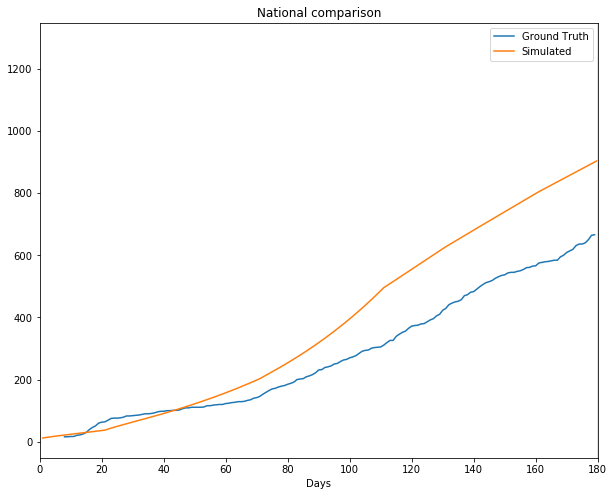

In [8]:
#New
plt.figure(figsize=(10,8))
ax = plt.gca()
evd_df2 = pd.read_csv(..\data\Ebola_Updated_Jan23.csv.csv', delimiter='\t')
evd_df2['Date'] = evd_df2.date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
gt2 = evd_df2[evd_df2.health_zone=='all'].total_c.values
ax.plot(gt2,label='Ground Truth')
out_df.sum().cumsum().plot(label='Simulated',ax=ax)
ax.axvline(len(gt2),color='#dbdbdb')
plt.title('National comparison')
plt.xlabel('Days')
plt.legend()
plt.xlim([0,len(gt2)+30])

plt.xlim([0,len(gt2)])


In [26]:
evd_df2['date'].nunique()

180

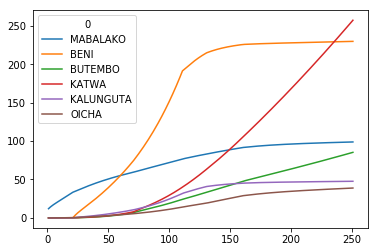

In [27]:
out_df.loc[key_hzs].T.cumsum().plot()

In [28]:
out_df.loc[key_hzs]

,1,2,3,4,5,6,7,8,9,10,...,242,243,244,245,246,247,248,249,250,251
0,,,,,,,,,,,,,,,,,,,,,
MABALAKO,12.0,1.477506,1.329745,1.220964,1.141625,1.084532,1.044258,1.016709,0.998794,0.988186,...,0.044794,0.044514,0.044246,0.043988,0.043741,0.043504,0.043276,0.043058,0.042849,0.042648
BENI,0.0,0.013743,0.012369,0.011471,0.010927,0.010645,0.010557,0.010614,0.010776,0.011017,...,0.037382,0.037406,0.037432,0.037460,0.037489,0.037519,0.037551,0.037584,0.037618,0.037653
BUTEMBO,0.0,0.007109,0.006398,0.005940,0.005669,0.005536,0.005506,0.005552,0.005654,0.005798,...,0.439311,0.440162,0.441016,0.441871,0.442729,0.443588,0.444450,0.445313,0.446178,0.447044
KATWA,0.0,0.009681,0.008713,0.008086,0.007713,0.007527,0.007480,0.007536,0.007667,0.007856,...,1.813164,1.816811,1.820460,1.824112,1.827766,1.831423,1.835083,1.838746,1.842412,1.846080
KALUNGUTA,0.0,0.006575,0.005918,0.005491,0.005236,0.005107,0.005073,0.005107,0.005194,0.005318,...,0.017343,0.017324,0.017307,0.017291,0.017278,0.017267,0.017257,0.017249,0.017242,0.017237
OICHA,0.0,0.011246,0.010121,0.009388,0.008946,0.008718,0.008650,0.008700,0.008837,0.009039,...,0.074795,0.074532,0.074281,0.074041,0.073812,0.073593,0.073385,0.073187,0.072998,0.072818


# Regional ground truth vs simulated cases 


### Stage Parameters

### I) Stage 0: seed Mabalako (0-20)
#####    |beta| |alpha| |gamma|

##### MABALAKO 0.15 0.133 0.1

### II) Stage 1: seed beni (20-70)
#####    |beta| |alpha| |gamma|

##### MABALAKO 0.09 0.133 0.1

##### BENI 0.13 0.133 0.1

##### OICHA 0.00 0.133 0.1

##### KATWA 0.25 0.133 0.1

##### BUTEMBO 0.2 0.133 0.1




### III) Stage 2: seed butembo and katwa (70-110)
#####    |beta| |alpha| |gamma|

##### BENI 0.25 0.133 0.1  *** stg2 Beni 1.923 x stg1 Beni

##### BUTEMBO 0.1 0.133 0.1  *** stg2 Butembo 0.5 x stg1 Butembo

##### KATWA 0.13 0.133 0.1  *** ...

##### OICHA 0.00 0.133 0.1  *** ...

##### MABALAKO 0.09 0.133 0.1  *** same



### IV) Stage 3: (110-140)
#####    |beta| |alpha| |gamma|

##### BENI 0.12 0.133 0.1 *** stg3 Beni 0.48 x stg2 Beni

##### BUTEMBO 0.07 0.133 0.1 *** stg3 Butembo 0.7 x stg2 Butembo

##### KATWA 0.14 0.133 0.1

##### OICHA 0.04 0.133 0.1

##### MABALAKO 0.09 0.133 0.1



### V) Stage 4 (140-160)
#####    |beta| |alpha| |gamma|
##### BENI 0.08 0.133 0.1 *** stg4 Beni 0.667 x st3 Beni

##### BUTEMBO 0.06 0.133 0.1

##### KATWA 0.15 0.133 0.1

##### OICHA 0.06 0.133 0.1

##### KALUNGUTA 0.06 0.133 0.1

##### MABALAKO 0.08 0.133 0.1



### VI) Stage 5 (160-around 180)
#####    |beta| |alpha| |gamma|
##### BENI 0.02 0.133 0.1  *** stg5 Beni 0.25 x stg4 Beni

##### BUTEMBO 0.03 0.133 0.1

##### KATWA 0.15 0.133 0.1

##### OICHA 0.04 0.133 0.1

##### KALUNGUTA 0.04 0.133 0.1

##### MABALAKO 0.06 0.133 0.1


### Notes For Below Plots 

* Grey axv lines to separate stages. 
* Blue axv line indicates the end of Ground Truth Data x limit
* Past Blue line is projected data



#### Plot Without Projection 

(0, 180)

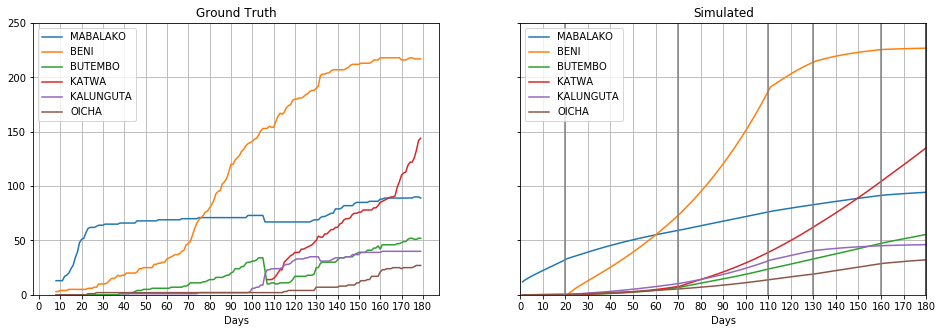

In [29]:
#Setting up Ground Truths Plot 
f,axarr = plt.subplots(1,2,figsize=(16,5),sharey=True)
key_hzs = ['MABALAKO','BENI','BUTEMBO','KATWA','KALUNGUTA','OICHA'] #Setting what health zones we are looking at 
for h in key_hzs:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c',ax=axarr[0],label=h)
axarr[0].set_title('Ground Truth')
axarr[0].set_xlabel('Days')
axarr[0].set_ylim(0,250)

#Setting up the Simulated Plot 
out_df.loc[key_hzs].T.cumsum().plot(ax=axarr[1])
axarr[1].set_title('Simulated')
axarr[1].set_xlabel('Days')

## AXV LINES:
axarr[1].axvline(len(gt2),color='b') #End of Grounded Truth Data 

axarr[1].axvline(20,color='grey') #End of Stage 0
axarr[1].axvline(70,color='grey') #End of stage 1
axarr[1].axvline(110,color='grey') #End of stage 2 
axarr[1].axvline(130,color='grey') #End of Stage 3a
axarr[1].axvline(160,color='grey') #End of stage 4

#Setting Grid lines and setting the axis settings in intervals of 'n'
axarr[0].grid(which='major', axis='both', linestyle='-')
axarr[1].grid(which='major', axis='both', linestyle='-')
loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
axarr[0].xaxis.set_major_locator(loc)
axarr[1].xaxis.set_major_locator(loc)

#Setting up x limit and title of saved graph 
l = axarr[1].legend()
l.set_title('')
plt.xlim([0,len(gt2)+30]) 


#Setting the limift for Simulated Graph. This is what sets the projected data date
axarr[1].set_xlim([0,len(gt2)])


#### Plot With Projection 

(0, 230)

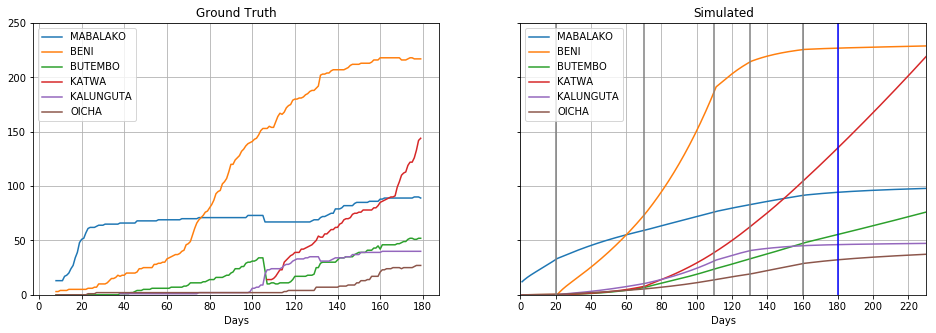

In [30]:
#Setting up Ground Truths Plot 
f,axarr = plt.subplots(1,2,figsize=(16,5),sharey=True)
key_hzs = ['MABALAKO','BENI','BUTEMBO','KATWA','KALUNGUTA','OICHA'] #Setting what health zones we are looking at 
for h in key_hzs:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c',ax=axarr[0],label=h)
axarr[0].set_title('Ground Truth')
axarr[0].set_xlabel('Days')
axarr[0].set_ylim(0,250)

#Setting up the Simulated Plot 
out_df.loc[key_hzs].T.cumsum().plot(ax=axarr[1])
axarr[1].set_title('Simulated')
axarr[1].set_xlabel('Days')

## AXV LINES:
axarr[1].axvline(len(gt2),color='b') #End of Grounded Truth Data 

axarr[1].axvline(20,color='grey') #End of Stage 0
axarr[1].axvline(70,color='grey') #End of stage 1
axarr[1].axvline(110,color='grey') #End of stage 2 
axarr[1].axvline(130,color='grey') #End of Stage 3a
axarr[1].axvline(160,color='grey') #End of stage 4

#Setting Grid lines and setting the axis settings in intervals of 'n'
axarr[0].grid(which='major', axis='both', linestyle='-')
axarr[1].grid(which='major', axis='both', linestyle='-')
loc = plticker.MultipleLocator(base=20) # this locator puts ticks at regular intervals
axarr[0].xaxis.set_major_locator(loc)
axarr[1].xaxis.set_major_locator(loc)

#Setting up x limit and title of saved graph 
l = axarr[1].legend()
l.set_title('')
plt.xlim([0,len(gt2)+50]) 


#Setting the limift for Simulated Graph. This is what sets the projected data date
axarr[1].set_xlim([0,len(gt2)+50])


# Plotting Ground Truth And Simulated Health Zone Data Two At A Time: 

### Katwa and Beni 
#### - - - is the simulated 

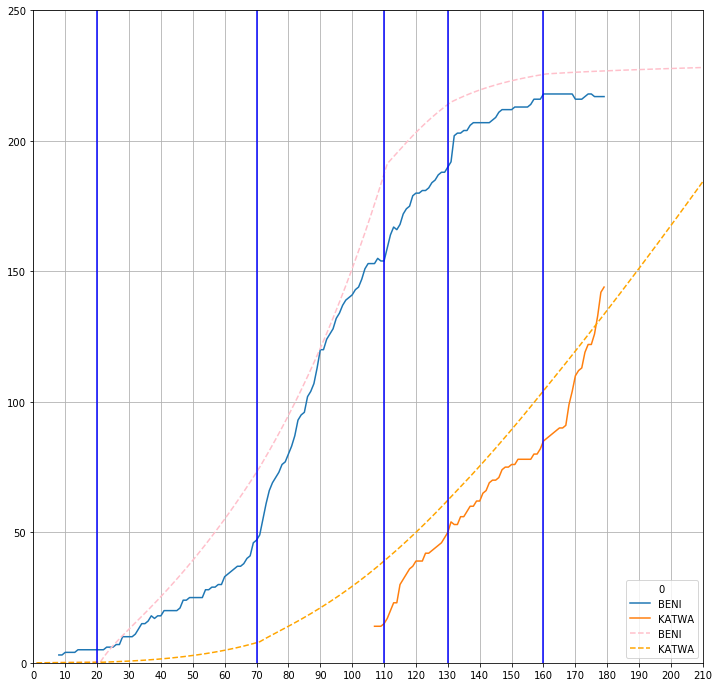

In [31]:
import matplotlib.ticker as plticker

#Setting up Ground Truths Plot 
colors=['pink', 'orange', 'green', 'red', 'blue', 'black']
f,ax = plt.subplots(figsize=(12,12),sharex=True)
key_hzs_2 = ['BENI','KATWA']
for h in key_hzs_2:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c', ax=ax, label=h, x_compat=True)

#Setting up the Simulated Plot 
out_df.loc[key_hzs_2].T.cumsum().plot(ax=ax, style='--', color=colors)

## AXV LINES:
ax.axvline(20,color='b') #End of Stage 0
ax.axvline(70,color='b') #End of stage 1
ax.axvline(110,color='b') #End of stage 2 
ax.axvline(130,color='b') #End of Stage 3a
ax.axvline(160,color='b') #End of stage 4

#Plot Settings 
plt.xlim([0,len(gt2)+30])
loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.ylim(0,250)
plt.grid()                                  
plt.show()

                                    

### Mabalaki and Butembo
#### - - - is the simulated 

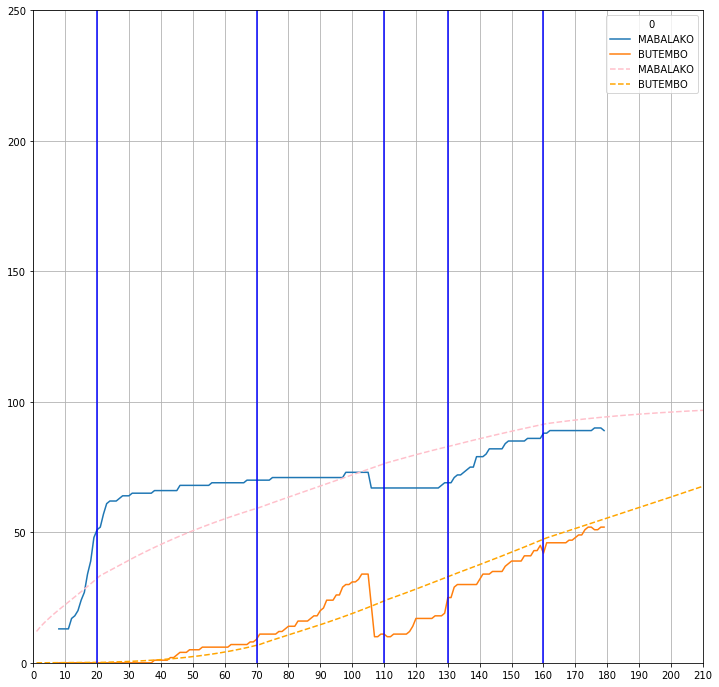

In [32]:
import matplotlib.ticker as plticker

#Setting up Ground Truths Plot 
colors=['pink', 'orange', 'green', 'red', 'blue', 'black']
f,ax = plt.subplots(figsize=(12,12),sharex=True)
key_hzs_2 = ['MABALAKO', 'BUTEMBO']
for h in key_hzs_2:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c', ax=ax, label=h, x_compat=True)

#Setting up the Simulated Plot 
out_df.loc[key_hzs_2].T.cumsum().plot(ax=ax, style='--', color=colors)

## AXV LINES:
ax.axvline(20,color='b') #End of Stage 0
ax.axvline(70,color='b') #End of stage 1
ax.axvline(110,color='b') #End of stage 2 
ax.axvline(130,color='b') #End of Stage 3a
ax.axvline(160,color='b') #End of stage 4

#Plot Settings 
plt.xlim([0,len(gt2)+30])
loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.ylim(0,250)
plt.grid()                                  
plt.show()

# Save the image in memory in PNG format
png1 = io.BytesIO()


# Load this image into PIL
png2 = Image.open(png1)

# Save as TIFF

                         

### KALUNGUTA and OICHA
#### - - - is the simulated 

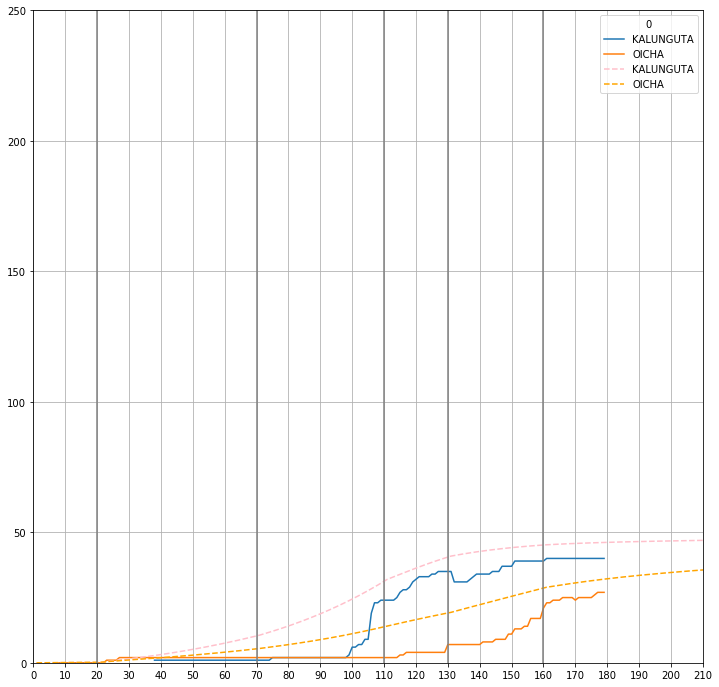

In [33]:
import matplotlib.ticker as plticker

#Setting up Ground Truths Plot 
colors=['pink', 'orange', 'green', 'red', 'blue', 'black']
f,ax = plt.subplots(figsize=(12,12),sharex=True)
key_hzs_2 = ['KALUNGUTA','OICHA']
for h in key_hzs_2:
    evd_df2[evd_df2.health_zone==h.capitalize()].reset_index().plot(y='total_c', ax=ax, label=h, x_compat=True)

#Setting up the Simulated Plot 
out_df.loc[key_hzs_2].T.cumsum().plot(ax=ax, style='--', color=colors)

## AXV LINES:
ax.axvline(20,color='grey') #End of Stage 0
ax.axvline(70,color='grey') #End of stage 1
ax.axvline(110,color='grey') #End of stage 2 
ax.axvline(130,color='grey') #End of Stage 3a
ax.axvline(160,color='grey') #End of stage 4

#Plot Settings 
plt.xlim([0,len(gt2)+30])
loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.ylim(0,250)
plt.grid()                                  
plt.show()
                  

### Risk profile for health zones

In [34]:
# ### Converting to Weekly case counts
# out_df.index = out_df.index.str.replace('_',' ')
# out_wk = out_df.groupby((out_df.columns - 1)// 7, axis=1).sum()
# wk_range = out_wk.columns[:-1]
# out_wk = out_wk[wk_range]

# out_wk['Last4'] = out_wk[wk_range[-4:]].sum(axis=1)
# temp_df = out_wk.sort_values('Last4',ascending=False)[['Last4']]
# temp_df['risk_index'] = temp_df.Last4/temp_df.Last4.sum()
# temp_df[['risk_index']].head(10).to_html('../plots/risk_table_sc{}.html'.format(sc))

### Visualizing weekly choropleths

In [35]:
# gdf = gpd.read_file('../data/shapefile/healthzones_v2/DRC_Districts.shp').set_index('ADM2_NAME')
# gdf = gdf.join(out_wk)
# count=0
# for wk in wk_range:
#     f = plt.figure(figsize=(10,10))
#     ax = plt.gca()
#     plt.axis('off')
#     plt.title('Simulated cases in week {}'.format(wk),fontsize=20)
#     gdf[(gdf.ADM1_NAME.isin(['ITURI','NORD KIVU']))].plot(ax=ax,column=wk,cmap='Reds',vmin=0,vmax=10,legend=True)
#     #gdf.plot(ax=ax,column=wk,cmap='Reds',vmin=0,vmax=10,legend=True)
#     display.clear_output(wait=True)
#     display.display(pl.gcf())    
#     plt.savefig('../plots/{:02d}_temp.png'.format(count),bbox_inches='tight')
#     count+=1
#     plt.close()

# cmd_str = "convert -delay 100 -loop 1 ../plots/*.png ../plots/sim_anim_nk_sc{}.gif".format(sc)
# call(cmd_str.split(' '))
# [os.remove('../plots/'+x) for x in os.listdir('../plots') if '_temp.png' in x];

In [36]:
# plt.figure(figsize=(20,20))
# ax = plt.gca()
# gdf = gpd.read_file('../data/shapefile/healthzones_v2/DRC_Districts.shp')
# gdf[gdf.ADM1_NAME.isin(['ITURI','NORD KIVU'])].plot(ax=ax)
# for hz in gdf[gdf.ADM1_NAME.isin(['ITURI','NORD KIVU'])]['ADM2_NAME'].values:
#     plt.annotate(s=hz, xy=(gdf[gdf.ADM2_NAME==hz]['CENTER_LON'],gdf[gdf.ADM2_NAME==hz]['CENTER_LAT']),
#                  horizontalalignment='center')

## Comparing the two scenarios

In [37]:
out_dict = {}

In [38]:
sc = 'a'
out_df = pd.DataFrame()
for s in range(stages):
    if s!=3:
        temp_df = pd.read_csv('../outputs/sample{}.out'.format(s),delimiter=' ',header=None,index_col=0)
    else:
        temp_df = pd.read_csv('../outputs/sample{}{}.out'.format(s,sc),delimiter=' ',header=None,index_col=0)
        
    if s==0:
        out_df = temp_df.copy(deep=True)
    else:
        temp_df.columns = [x+len(out_df.columns) for x in temp_df.columns]
        out_df = out_df.join(temp_df)
out_dict[sc] = out_df

In [39]:
out_dict.keys()

dict_keys(['a'])

In [40]:
horizon = 30
chop = 90-horizon

curve_a = out_dict['a'].sum().cumsum().values
print('Percentage Increase in baseline after {} days horizon in comparison to current state: {}%'.format(horizon,round((curve_a[-1-chop]-curve_a[-91])*100/curve_a[-91],2)))

tot_a = out_dict['a'].sum().cumsum().values[-1-chop]
tot_b = out_dict['a'].sum().cumsum().values[-1-chop]
print('Percentage Increase due to pull-out at {} days horizon in comparison to baseline: {}%'.format(horizon,round((tot_b-tot_a)*100/tot_a,2)))
#print(int(tot_a),int(tot_b))

Percentage Increase in baseline after 30 days horizon in comparison to current state: 19.74%
Percentage Increase due to pull-out at 30 days horizon in comparison to baseline: 0.0%


In [41]:
tot_b

963.1625401696583

In [42]:
tot_a

963.1625401696583